<a href="https://colab.research.google.com/github/AllanMogley/03-Machine-Learning-Works/blob/main/YOLOV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model
!dir

/content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model
annotations  images  yolov5


In [ ]:
# !git clone https://github.com/ultralytics/yolov5

In [ ]:
# pip install -r yolov5/requirements.txt

In [2]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [3]:
# !mkdir Datasets
# %cd Trained\ Model
# %cd ..
!dir

annotations  images  yolov5


In [ ]:
# !unzip annotations.zip

In [ ]:
# Assuming you're in the data folder
!cat annotations/odm_orthophoto_2_1.xml

In [6]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(subelem.text)

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = subsubelem.text
            info_dict['bboxes'].append(bbox)

    return info_dict

In [7]:
print(extract_info_from_xml('annotations/odm_orthophoto_1_1.xml'))

{'bboxes': [{'class': 'Others', 'xmin': '507.57', 'ymin': '566.86', 'xmax': '527.27', 'ymax': '583.2'}, {'class': 'Others', 'xmin': '546.81', 'ymin': '96.0', 'xmax': '567.69', 'ymax': '115.71'}, {'class': 'Others', 'xmin': '581.52', 'ymin': '132.47', 'xmax': '599.17', 'ymax': '151.59'}, {'class': 'Others', 'xmin': '599.75', 'ymin': '126.59', 'xmax': '616.23', 'ymax': '142.47'}, {'class': 'Others', 'xmin': '573.87', 'ymin': '112.77', 'xmax': '589.46', 'ymax': '128.65'}, {'class': 'Others', 'xmin': '492.1', 'ymin': '32.76', 'xmax': '510.33', 'ymax': '52.76'}, {'class': 'Others', 'xmin': '377.08', 'ymin': '54.39', 'xmax': '399.89', 'ymax': '71.24'}, {'class': 'Others', 'xmin': '349.79', 'ymin': '120.65', 'xmax': '376.56', 'ymax': '147.71'}, {'class': 'Maize', 'xmin': '538.15', 'ymin': '279.88', 'xmax': '575.63', 'ymax': '335.16'}, {'class': 'Others', 'xmin': '625.46', 'ymin': '75.31', 'xmax': '646.62', 'ymax': '94.6'}, {'class': 'Others', 'xmin': '715.5', 'ymin': '558.0', 'xmax': '742.2',

In [ ]:
info_dict["image_size"]

In [9]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Maize": 0,
                           "Grass": 1,
                           "Others": 2}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = float((b["xmin"])) + float((b["xmax"])) / 2
        b_center_y = float((b["ymin"])) + float((b["ymax"])) / 2
        b_width    = float((b["xmax"])) - float((b["xmin"]))
        b_height   = float((b["ymax"])) - float((b["ymin"]))

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        # b_center_x /= int(image_w)
        # b_center_y /= int(image_h)
        # b_width    /= int(image_w)
        # b_height   /= int(image_h)

# ===============================================================================
        b_center_x /= 2000
        b_center_y /= 2000
        b_width    /= 2000
        b_height   /= 2000
# ===============================================================================


        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("tif", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
%cd /content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model

/content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model


In [11]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 11/11 [00:02<00:00,  4.80it/s]


In [12]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[y for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "tif")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

IndexError: ignored

In [13]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [15]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [18]:
!mv annotations2 labels
# %cd ../yolov5
%cd yolov5
!dir

mv: cannot stat 'annotations2': No such file or directory
/content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model/yolov5
benchmarks.py	 detect.py   __pycache__       segment	       val.py
CITATION.cff	 export.py   README.md	       setup.cfg       yolov5s.pt
classify	 hubconf.py  README.zh-CN.md   train.py
CONTRIBUTING.md  LICENSE     requirements.txt  tutorial.ipynb
data		 models      runs	       utils


In [ ]:
# !dir
%cd /content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model/yolov5

/content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model/yolov5


In [45]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data road_sign_data.yaml --weights yolov5s.pt --workers 24 --name weeds

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=road_sign_data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=weeds, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/MyDrive/02': No such file or directory
YOLOv5 🚀 2023-8-23 Python-3.10.12 torch-2.0.1+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_

In [40]:
!dir
# %cd yolov5

benchmarks.py	 detect.py   __pycache__       segment	       val.py
CITATION.cff	 export.py   README.md	       setup.cfg       yolov5s.pt
classify	 hubconf.py  README.zh-CN.md   train.py
CONTRIBUTING.md  LICENSE     requirements.txt  tutorial.ipynb
data		 models      runs	       utils


In [47]:
!python detect.py --source ../images/test/ --weights runs/train/weeds2/weights/best.pt --conf 0.25 --name weeds

detect: weights=['runs/train/weeds2/weights/best.pt'], source=../images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=weeds, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to '/content/drive/MyDrive/02': No such file or directory
YOLOv5 🚀 2023-8-23 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/2 /content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model/images/test/odm_orthophoto_1_3.tif: 480x640 (no detections), 332.9ms
image 2/2 /content/drive/MyDrive/02 - Project/03 - ML_WORKS/Trained Model/images/test/odm_orthophoto_2_1.tif: 480x640 (no detections), 299.3ms
Speed: 1.9

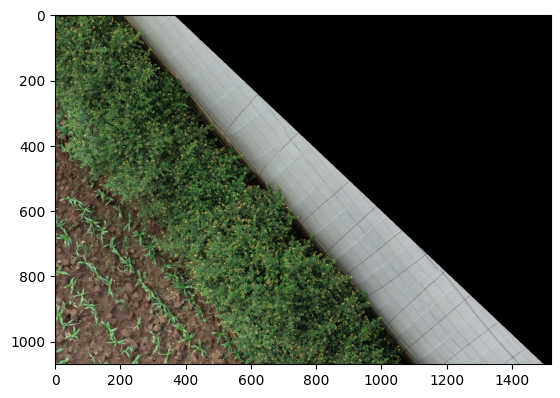

In [51]:
detections_dir = "runs/detect/weeds9/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))